# Creating a CNN for MNIST dataset

In [1]:
import time
import os
import random

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision as tv

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

num_workers = os.cpu_count()
print(num_workers)

cuda:0
24


In [3]:
# Reset RNG seed
random_state = 12345

random_state = int(random_state)
random.seed(random_state)
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed_all(random_state)
torch.backends.cudnn.deterministic = True

In [4]:
batch_size = 256
lr = 0.001
epochs = 50

In [5]:
# Load data
root = 'data'

transform = tv.transforms.Compose([
        tv.transforms.ToTensor(),
])
train_dataset = tv.datasets.MNIST(
    root,
    train=True, 
    download=True,
    transform=transform)
test_dataset = tv.datasets.MNIST(
    root,
    train=False, 
    download=True,
    transform=transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # We don't need to shuffle test set
)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(int(((28 - (3-1)) / 2)**2 * 8), 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)  # No need to call Softmax function
        return x
# CrossEntropyLoss combines LogSoftmax and NLLLoss

In [7]:

def train(model, loader, optimizer, loss):
    model.train()
    total_loss = 0.
    corrects = 0.
    
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        batch_size = x.size(0)
        
        optimizer.zero_grad()
        output = model(x)
        los = loss(output, y)
        los.backward()
        optimizer.step()

        # for display
        total_loss += los.item() * batch_size
        preds = output.max(1, keepdim=True)[1]
        corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [8]:
def validate(model, loader, loss):
    model.eval()
    total_loss = 0.
    corrects = 0.
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            batch_size = x.size(0)
            output = model(x)
            los = loss(output, y)
            total_loss += los.item() * batch_size
            preds = output.max(1, keepdim=True)[1]
            corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [9]:
cnn = Net()

In [10]:
# Test model
x, _ = next(iter(test_loader))
print(x.size())

out = cnn(x)
print(out.size())

torch.Size([256, 1, 28, 28])
torch.Size([256, 10])


In [11]:
# Move model to GPU
cnn.to(device)

# Define loss function and optimization method
optimizer = torch.optim.SGD(cnn.parameters(), lr=lr, momentum=0.9)
loss = nn.CrossEntropyLoss()

In [12]:
train_losses = np.zeros(epochs, dtype=np.float)
test_losses = np.zeros(epochs, dtype=np.float)
train_accs = np.zeros(epochs, dtype=np.float)
test_accs = np.zeros(epochs, dtype=np.float)

since = time.time()
for i, epoch in enumerate(range(epochs)):
    start = time.time()
    train_losses[i], train_accs[i] = train(cnn, train_loader, optimizer, loss)
    test_losses[i], test_accs[i] = validate(cnn, test_loader, loss)
    
    time_elapsed = time.time() - start
    print(('[{:2d}] {:.0f}m {:.1f}s Train Loss: {:.4f} Accuracy: {:.4f}%, ' +
        'Test Loss: {:.4f} Accuracy: {:.4f}%').format(
            epoch+1, time_elapsed // 60, time_elapsed % 60,
            train_losses[i], train_accs[i]*100.,
            test_losses[i], test_accs[i]*100.))
    
time_elapsed = time.time() - since
print('Total run time: {:.0f}m {:.1f}s'.format(
    time_elapsed // 60,
    time_elapsed % 60))

[ 1] 0m 4.9s Train Loss: 2.1851 Accuracy: 39.3683%, Test Loss: 1.8941 Accuracy: 69.3500%
[ 2] 0m 3.3s Train Loss: 1.2397 Accuracy: 75.2050%, Test Loss: 0.6356 Accuracy: 85.5500%
[ 3] 0m 3.3s Train Loss: 0.5982 Accuracy: 85.5867%, Test Loss: 0.4149 Accuracy: 88.9000%
[ 4] 0m 3.4s Train Loss: 0.4695 Accuracy: 87.8717%, Test Loss: 0.3521 Accuracy: 90.0900%
[ 5] 0m 3.3s Train Loss: 0.4168 Accuracy: 88.9717%, Test Loss: 0.3251 Accuracy: 90.8300%
[ 6] 0m 3.3s Train Loss: 0.3853 Accuracy: 89.7933%, Test Loss: 0.3039 Accuracy: 91.1800%
[ 7] 0m 3.3s Train Loss: 0.3629 Accuracy: 90.2217%, Test Loss: 0.2869 Accuracy: 91.7100%
[ 8] 0m 3.3s Train Loss: 0.3468 Accuracy: 90.7517%, Test Loss: 0.2747 Accuracy: 92.1100%
[ 9] 0m 3.3s Train Loss: 0.3293 Accuracy: 91.2033%, Test Loss: 0.2611 Accuracy: 92.5200%
[10] 0m 3.3s Train Loss: 0.3124 Accuracy: 91.6100%, Test Loss: 0.2517 Accuracy: 92.7600%
[11] 0m 3.3s Train Loss: 0.3024 Accuracy: 91.9067%, Test Loss: 0.2395 Accuracy: 93.1000%
[12] 0m 3.3s Train Lo

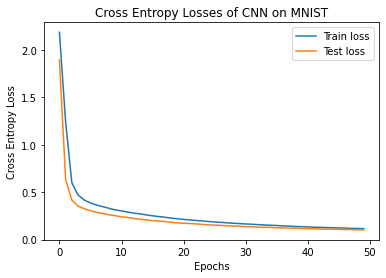

In [16]:
plt.figure()
plt.plot(range(epochs), train_losses, label='Train loss')
plt.plot(range(epochs), test_losses, label='Test loss')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.legend()
plt.title('Cross Entropy Losses of CNN on MNIST')
plt.show()

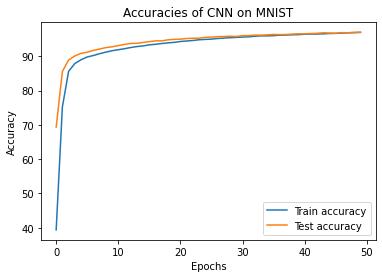

In [17]:
plt.figure()
plt.plot(range(epochs), train_accs*100.0, label='Train accuracy')
plt.plot(range(epochs), test_accs*100.0, label='Test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.title('Accuracies of CNN on MNIST')
plt.show()